In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
import os
from tqdm import tqdm

# -----------------------
# Chuẩn bị MNIST
# -----------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

num_clients = 20
alpha = 5.0
test_size = 0.2

# -----------------------
# Thư mục lưu dữ liệu
# -----------------------
os.makedirs("../simulate/volumes", exist_ok=True)

train_data_all = list(zip(train_dataset.data, train_dataset.targets))
test_data_all  = list(zip(test_dataset.data, test_dataset.targets))

train_labels = np.array([t.item() for t in train_dataset.targets])
test_labels  = np.array([t.item() for t in test_dataset.targets])
num_classes = 10

# -----------------------
# Tạo dữ liệu client không trùng lặp
# -----------------------
# Tạo index sẵn để chia train/test
train_indices_all = np.arange(len(train_data_all))
test_indices_all  = np.arange(len(test_data_all))

# Shuffle trước
np.random.shuffle(train_indices_all)
np.random.shuffle(test_indices_all)

# Dirichlet proportions cho train
proportions_train = np.random.dirichlet([alpha]*num_clients)
proportions_train = (proportions_train / proportions_train.sum() * len(train_data_all)).astype(int)

# Dirichlet proportions cho test
proportions_test = np.random.dirichlet([alpha]*num_clients)
proportions_test = (proportions_test / proportions_test.sum() * len(test_data_all)).astype(int)

# Điều chỉnh cho khớp tổng số
proportions_train[-1] = len(train_data_all) - proportions_train[:-1].sum()
proportions_test[-1]  = len(test_data_all)  - proportions_test[:-1].sum()

train_ptr = 0
test_ptr  = 0

for i in tqdm(range(num_clients), desc="Creating client datasets"):
    client_path = f"../simulate/volumes/client{i+1}"
    os.makedirs(client_path, exist_ok=True)

    # Lấy index cho client i
    train_indices = train_indices_all[train_ptr:train_ptr+proportions_train[i]]
    test_indices  = test_indices_all[test_ptr:test_ptr+proportions_test[i]]

    train_ptr += proportions_train[i]
    test_ptr  += proportions_test[i]

    # Lấy dữ liệu thực tế
    train_data = [train_data_all[idx] for idx in train_indices]
    test_data  = [test_data_all[idx]  for idx in test_indices]

    # Lưu
    torch.save(train_data, f"{client_path}/train.pt")
    torch.save(test_data, f"{client_path}/test.pt")

print("✅ Saved all client datasets with non-overlapping Dirichlet splits")

Creating client datasets: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]

✅ Saved all client datasets with non-overlapping Dirichlet splits


In [3]:
num_clients = 20
num_classes = 10

100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


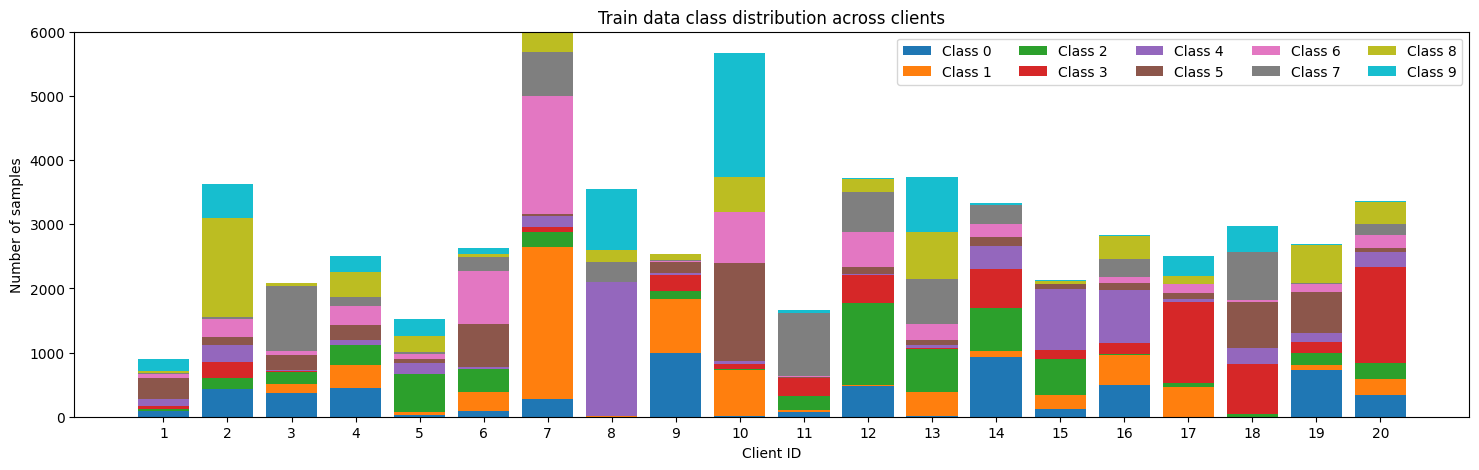

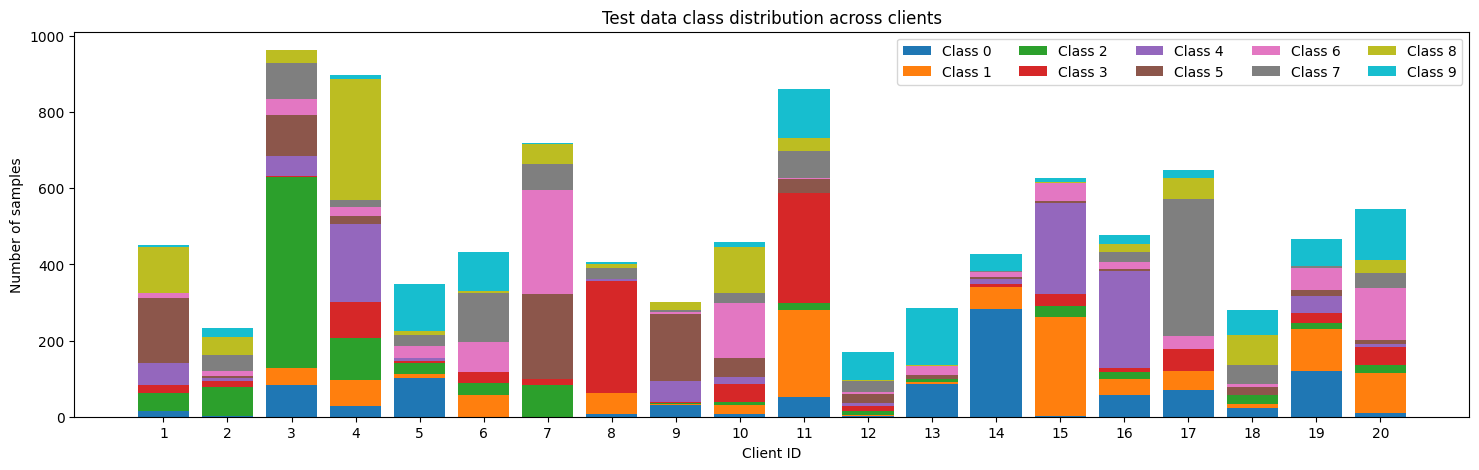

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Đếm theo class cho mỗi client
train_class_counts = np.zeros((num_clients, num_classes), dtype=int)
test_class_counts  = np.zeros((num_clients, num_classes), dtype=int)

for i in tqdm(range(num_clients)):
    client_path = f"../simulate/volumes2/client{i+1}"
    train_data = torch.load(f"{client_path}/train.pt")
    test_data  = torch.load(f"{client_path}/test.pt")

    train_labels_client = [y.item() for _, y in train_data]
    test_labels_client  = [y.item() for _, y in test_data]

    for c in range(num_classes):
        train_class_counts[i, c] = np.sum(np.array(train_labels_client) == c)
        test_class_counts[i, c]  = np.sum(np.array(test_labels_client) == c)

x = np.arange(1, num_clients+1)  # bắt đầu từ 1

# Train stacked bar
fig1, ax1 = plt.subplots(figsize=(18, 5))
bottom = np.zeros(num_clients)
colors = plt.cm.tab10.colors

for c in range(num_classes):
    ax1.bar(x, train_class_counts[:, c], bottom=bottom, color=colors[c], label=f"Class {c}")
    bottom += train_class_counts[:, c]

ax1.set_title("Train data class distribution across clients")
ax1.set_ylabel("Number of samples")
ax1.set_xlabel("Client ID")
ax1.set_xticks(x)  # hiển thị tất cả các số nguyên
ax1.set_xticklabels(x)  # đảm bảo là số nguyên
ax1.legend(ncol=5, loc="upper right")

# Test stacked bar
fig2, ax2 = plt.subplots(figsize=(18, 5))
bottom = np.zeros(num_clients)

for c in range(num_classes):
    ax2.bar(x, test_class_counts[:, c], bottom=bottom, color=colors[c], label=f"Class {c}")
    bottom += test_class_counts[:, c]

ax2.set_title("Test data class distribution across clients")
ax2.set_ylabel("Number of samples")
ax2.set_xlabel("Client ID")
ax2.set_xticks(x)
ax2.set_xticklabels(x)
ax2.legend(ncol=5, loc="upper right")

plt.show()